# Baichuan2-7B LoRA微调 ModelScope

使用了ModelScope平台 

fp16精度下LoRA微调，需要24GB的显卡

## 安装环境

In [ ]:
!pip install -q accelerate
!pip install -q peft
!pip install -q torchkeras

## 0 Baichuan2-7B-Chat 预训练模型

In [2]:
from modelscope.hub.snapshot_download import snapshot_download

model_dir = snapshot_download('baichuan-inc/baichuan2-7B-Chat', cache_dir='baichuan2-7B-Chat', revision='v1.0.1')

2023-09-20 19:54:52,246 - modelscope - INFO - Use user-specified model revision: v1.0.1
Downloading: 100%|██████████| 22.0/22.0 [00:00<00:00, 3.21kB/s]
Downloading: 100%|██████████| 215/215 [00:00<00:00, 160kB/s]
Downloading: 100%|██████████| 2.39k/2.39k [00:00<00:00, 2.03MB/s]
Downloading: 100%|██████████| 285/285 [00:00<00:00, 233kB/s]
Downloading: 100%|██████████| 2.90k/2.90k [00:00<00:00, 2.23MB/s]
Downloading: 100%|██████████| 32.3k/32.3k [00:00<00:00, 892kB/s]
Downloading: 100%|██████████| 3.28k/3.28k [00:00<00:00, 2.47MB/s]
Downloading: 100%|█████████▉| 9.25G/9.25G [04:19<00:00, 38.3MB/s]
Downloading: 100%|█████████▉| 4.73G/4.73G [03:13<00:00, 26.2MB/s]
Downloading: 100%|██████████| 18.2k/18.2k [00:00<00:00, 643kB/s]
Downloading: 100%|██████████| 8.93k/8.93k [00:00<00:00, 5.17MB/s]
Downloading: 100%|██████████| 8.55k/8.55k [00:00<00:00, 5.78MB/s]
Downloading: 100%|██████████| 548/548 [00:00<00:00, 437kB/s]
Downloading: 100%|██████████| 9.39k/9.39k [00:00<00:00, 6.31MB/s]
Downloa

In [1]:
# import sys
# sys.path.append("/mnt/workspace/baichuan-7B/baichuan-inc/baichuan-7B")

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation.utils import GenerationConfig

import torch

model_path = "baichuan2-7B-Chat/baichuan-inc/baichuan2-7B-Chat"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path,device_map="auto", torch_dtype=torch.float16, trust_remote_code=True)
model.generation_config = GenerationConfig.from_pretrained(model_path)

# 用fp16加载，约占用15.3GB的显存

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
messages = []
messages.append({"role": "user", "content": "解释一下“温故而知新”"})
response = model.chat(tokenizer, messages)
print("Baichuan2: ", response)

Baichuan2:  "温故而知新"是一个中国古代成语，出自《论语·为政》。它的意思是通过回顾和了解过去的事情，可以从中获得新的知识和启示。这个成语强调了学习和知识的重要性，以及通过不断复习和总结来提高自己的重要性。

这个成语的内涵包括两个方面：一是要善于学习，二是要善于总结。善于学习意味着要不断学习新知识，拓宽自己的视野；善于总结意味着要学会从过去的经验中汲取教训，以便更好地应对未来的挑战。总之，"温故而知新"是一种积极的学习态度和方法，有助于个人和社会的发展和进步。


### 微调前的效果：

In [6]:
prompt_text = "你现在是一个信息抽取模型，请你帮我抽取出关系内容为\"性能故障\", \"部件故障\", \"组成\"和 \"检测工具\"的相关三元组，三元组内部用\"_\"连接，三元组之间用\\n分割。文本："

def get_prompt(text):
    return prompt_text + text

In [11]:
messages = []
messages.append({"role": "user", "content": get_prompt("故障现象：奔腾B70做PDI检查时车辆无法启动。")})
response = model.chat(tokenizer, messages)
print("Baichuan2: ", response)

Baichuan2:  性能故障_部件故障_组成_检测工具


## 1 加载训练数据

In [12]:
from torch.utils.data import DataLoader, RandomSampler
from data_set import Seq2SeqDataSet2, coll_fn

train_path = "dataset/spo_0.json"
max_len = 2048
max_src_len = 1280
batch_size = 2

train_dataset = val_dataset = Seq2SeqDataSet2(train_path, tokenizer, max_len, max_src_len, prompt_text)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              sampler=RandomSampler(train_dataset),
                              collate_fn=coll_fn,
                              drop_last=True,
                              num_workers=2)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=coll_fn,
                            num_workers=2)

In [13]:
for batch in train_dataloader:
    break

batch.keys()

dict_keys(['input_ids', 'labels'])

In [14]:
batch['input_ids'].shape

torch.Size([2, 2048])

## 2 定义模型

In [17]:
from peft import get_peft_model, LoraConfig, TaskType

model.supports_gradient_checkpointing = True  #节约cuda，但可能会使得训练时间变长
model.gradient_checkpointing_enable() # 作用同上
model.enable_input_require_grads() # 作用同上

model.config.use_cache = False  # 关闭了模型的缓存机制，该设置可以避免一些警告，但在模型推理时需要重新开启

# 配置LORA模型的类
# 常规LM任务
# 非推理模式
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    target_modules=["W_pack"],
    inference_mode=False,
    r=8,
    lora_alpha=32, 
    lora_dropout=0.1,
)

# 结合Lora和原有模型
model = get_peft_model(model, peft_config)
# 开启模型的并行处理能力，这可以在有多个GPU的情况下提高训练效率
model.is_parallelizable = True
model.model_parallel = True
# 打印出模型的可训练参数
model.print_trainable_parameters()
# 可训练参数：4,194,304
# 总参数量：7,510,167,552
# 需要调整的模型参数量的占比还是很低的 0.056%

trainable params: 4,194,304 || all params: 7,510,167,552 || trainable%: 0.055848341211549045


## 3 训练模型

In [19]:
from torchkeras import KerasModel
from accelerate import Accelerator
# 重写了torchkeras中的StepRunner类
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        # 计算loss
        with self.accelerator.autocast():
            # 通过模型self.net对输入数据进行预测，然后用预测结果和标签计算损失, loss的计算过程直接交给ChatGLM2了吗？
            loss = self.net.forward(**batch)[0]

        # 执行梯度下降的步骤
        if self.optimizer is not None and self.stage=="train":
            # 计算每个模型参数关于损失的梯度
            self.accelerator.backward(loss)
            # 执行梯度裁剪（self.accelerator.clip_grad_norm_），防止梯度爆炸
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            # 更新模型参数
            self.optimizer.step()
            # 存在学习率调整器，就调整学习率
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # 清空梯度
            self.optimizer.zero_grad()

        # 给并行计算和多GPU计算的损失收集起来并求和
        all_loss = self.accelerator.gather(loss).sum()

        # losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        # metrics (stateful metrics)
        step_metrics = {}

        # 记录过程信息，追踪模型性能用
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

# 仅仅保存lora可训练参数
# 覆盖了KerasModel中的load_ckpt和save_ckpt方法
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False

KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt

In [20]:
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'baichuan2-7B-chat_lora'

<<<<<< ⚡️ cuda is used >>>>>>


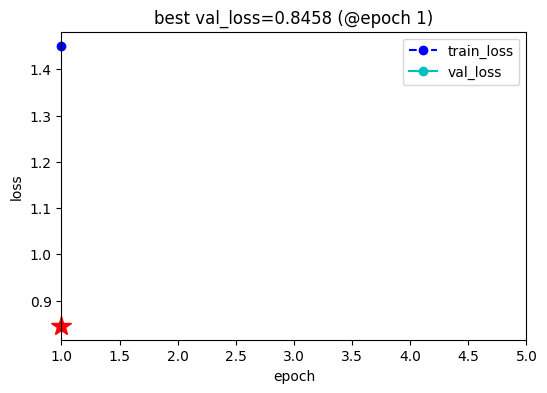

In [ ]:
keras_model.fit(train_data = train_dataloader,
                val_data = val_dataloader,
                epochs=5, patience=5,
                monitor='val_loss', mode='min',
                ckpt_path = ckpt_path,
               )

## 4 验证训练后结果



In [4]:
from peft import PeftModel

ckpt_path = 'baichuan2-7B-chat_lora'

model = PeftModel.from_pretrained(model, ckpt_path)
model = model.merge_and_unload() #合并lora权重

In [7]:
messages = []
messages.append({"role": "user", "content": get_prompt("故障现象：奔腾B70做PDI检查时车辆无法启动。")})
response = model.chat(tokenizer, messages)
print("Baichuan2: ", response)

2023-09-21 02:45:21.549898: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 02:45:21.589711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 02:45:22.555130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Baichuan2:  车辆_部件故障_无法启动


## 5 测试

In [11]:
import torch

def predict_one_sample(model, tokenizer, text):
    messages.append({"role": "user", "content": get_prompt(text)})
    with torch.no_grad():
        response = model.chat(tokenizer, messages)
    
    # 对结果按照“\n”进行分割，获取每个三元组内容
    pre_res = list(set([rr for rr in response.split('\n') if len(rr.split("_"))==3]))

    return response, pre_res

In [12]:
import json
import os
from tqdm.notebook import tqdm

test_path = "dataset/spo_1.json"
save_data = []
f1, total = 0.0, 0.0

with open(test_path, 'r', encoding='utf-8') as fh:
    for i, line in enumerate(tqdm(fh, desc="iter")):
        total += 1
        sample = json.loads(line.strip())
        response, pre_res = predict_one_sample(model, tokenizer, sample["text"])
        real_res = sample["answer"].split("\n")
        # 计算预测与真实的F1值
        same_res = set(pre_res) & set(real_res)
        if len(set(pre_res)) == 0:
            p = 0.0
        else:
            p = len(same_res) / len(set(pre_res))
        r = len(same_res) / len(set(real_res))
        if (p + r) != 0.0:
            f = 2 * p * r / (p + r)
        else:
            f = 0.0
        f1 += f 
        save_data.append(
            {"text": sample["text"], "ori_answer": sample["answer"], "gen_answer": response, "f1": f})
    
print("f1:", f1 / total)
save_path = os.path.join('baichuan2-7B-chat_lora', "ft_answer.json")
fin = open(save_path, "w", encoding="utf-8")
json.dump(save_data, fin, ensure_ascii=False, indent=4)
fin.close()

iter: 0it [00:00, ?it/s]

f1: 0.01
